Members:
Jason Yang 99407850 yangjyyhs@gmail.com
Baris Camli 64198302 bariscamli99@gmail.com
David Ho 25255993 a0966122021@gmail.com


Import the essential packages needed in this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
# Downloading stopwords dataset from NLTK (required for text preprocessing)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jasonyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

User defined functions & varaibles

In [2]:
# Get unique English stopwords from the NLTK corpus
stop_words = set(stopwords.words('english'))

# This function removes stopwords from a given text.
def remove_stopwords(text):
    cleaned_words = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

def get_keywords_tfidf(document_list):
    '''
    This function gets a list of documents as input and returns a list of top 10 keywords for each document using TF-IDF scores.
    Input: A list of documents (text)
    Output: The corresponding top 10 keywords for each document based on tf-idf values
    '''
    vectorizer = TfidfVectorizer() # Step 1: Create a TF-IDF vectorizer
    tfidf_matrix = vectorizer.fit_transform(document_list) # Step 2: Calculate the TF-IDF matrix
    feature_names = vectorizer.get_feature_names_out() # Step 3: Get feature names (words)

    # Step 4: Extract top 10 keywords for each document
    top_keywords = [] # accumulator
    for i in range(len(document_list)):
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        feature_value = [tfidf_matrix[i, x] for x in feature_index]
        tfidf_scores = zip(feature_index, feature_value)
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))

        if i % 200 == 199:
            print(f'Processed {i+1}/{len(document_list)} documents.')
    return top_keywords

# This function returns the top 10 most frequent words in a given text.
def get_top_keywords(text):
    c = Counter(str(text).split())
    words = []
    for pair in c.most_common(10):
        words.append(pair[0])
    return ' '.join(words) # contact all keywords in words list

# This function prints the 5 most similar words to a given word using a Word2Vec model.
def print_five_words(word):
    print(f'Similar words to "{word}" are :',", ".join([similar_words[0] for similar_words in word2vec_model.wv.most_similar(word)[:5]]))

Read the DataFrame

In [4]:
# Read corresponding data
df_mg = pd.read_csv("major_groups.csv")
df_pf = pd.read_csv("public_firms.csv")
df_10k = pd.read_csv("2020_10K_item1_full.csv")

# Duplicate check
print(df_mg.drop_duplicates().shape == df_mg.shape)
print(df_pf.drop_duplicates().shape == df_pf.shape)
print(df_10k.drop_duplicates().shape == df_10k.shape)

# Drop duplicates for only df_10k dataframe since it shows there're duplicates
df_10k.drop_duplicates(inplace=True)

True
True
False


***Part 1.Quantitative Analysis of the Industry Sector***

In [5]:
# Filter data only "Chemicals And Allied Products" sector
df_mg_chosen = df_mg[df_mg["description"] == "Chemicals And Allied Products"]
df_mg_chosen

,major_group,description
20,28,Chemicals And Allied Products


### The industry we choose:
### Chemicals And Allied Products
**Major Group Number:** 28


In [6]:
# Get the first "major group" code (SIC code)
sic_code = df_mg_chosen["major_group"].values[0]

# Create a new column 'sic_first_two' in df_pf by taking the first two digits of the 'sic' column
df_pf['sic_first_two'] = df_pf['sic'].astype(str).str[:2].astype(int)

# Filter the df_pf DataFrame where the first two digits of 'sic' match the major group (SIC code)
df_pf_chosen = df_pf[df_pf['sic_first_two'] == sic_code]

df_pf_chosen.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,sic_first_two
76,1034,1995,USA,ALPHARMA INC -CL A,NaN,2834,26.1250,18.351,18.817,634.853,520.882,0.029640,28
77,1034,1996,USA,ALPHARMA INC -CL A,NaN,2834,14.6250,15.944,-11.461,613.407,486.184,-0.018684,28
78,1034,1997,USA,ALPHARMA INC -CL A,NaN,2834,21.7500,10.997,17.408,631.866,500.288,0.027550,28
79,1034,1998,USA,ALPHARMA INC -CL A,NaN,2834,35.3125,14.414,24.211,908.936,604.584,0.026637,28
80,1034,1999,USA,ALPHARMA INC -CL A,NaN,2834,30.7500,17.655,36.972,1160.266,732.443,0.031865,28


### A. Industry Sector Selection and Data Filtering

1. **How many unique firm-year ("fyear") observations are there in the filtered dataset?**
2. **How many unique firms are there in the filtered dataset?**
3. **How many firms in the filtered dataset have records over all 27 years (1994-2020)?**

In [7]:
#A-Q1
uni_fyear = df_pf_chosen["fyear"].value_counts()
print(f" There are {len(uni_fyear)} unique fiscal years in the data")
#A-Q2
uni_firm = len(df_pf_chosen.groupby("gvkey"))
print(f" There are {uni_firm} unique firms in the data")
#A-Q3
df_pf_chosen_year = df_pf_chosen.groupby("gvkey").nunique()
companies_with_27_years = df_pf_chosen_year[df_pf_chosen_year["fyear"] == 27].index
company_names_with_27_years = df_pf_chosen[df_pf_chosen['gvkey'].isin(companies_with_27_years)]['conm'].unique().tolist()
print(f" There are {len(company_names_with_27_years)} companies that have records for all 27 years")

print("The 15 companies that have records for all 27 years are:")
print(company_names_with_27_years[:15])

 There are 27 unique fiscal years in the data
 There are 2276 unique firms in the data
 There are 15 companies that have records for all 27 years
The 15 companies that have records for all 27 years are:
['REX AMERICAN RESOURCES CORP', 'QUIDEL CORP', 'VIATRIS INC', 'BIOMERICA INC', 'POLYDEX PHARMACEUTICALS LTD', 'RPM INTERNATIONAL INC', 'REPLIGEN CORP', 'CYANOTECH CORP', 'SOLIGENIX INC', 'AVID BIOSERVICES INC', 'NEOGEN CORP', 'ADM TRONICS UNLIMITED INC/DE', 'ALKERMES PLC', 'GILEAD SCIENCES INC', 'MYMETICS CORP']


In [8]:
companies_with_27_years

Index([ 1864,  7526,  7637,  7662,  8666,  8902, 12181, 12575, 13484, 14603,
       16453, 21116, 24302, 24856, 31516],
      dtype='int64', name='gvkey')

### B. Preliminary Analysis

1. **What are the top 10 firms with the highest stock price (column "prcc_c") in the year 2020?**
2. **What are the top 10 firms with the highest sales (column "sale") in the entire history of the dataset?**
3. **What is the geographical distribution (column "location") of all the firms? In other words, how many firms are there in each location? Please list the top 10 locations.**
4. **Create a line chart to show the average stock price (column "prcc_c") in the selected sector(s) across the years. If you have selected multiple sectors, draw multiple lines to show them separately.**
5. **Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?**
6. **Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.**

In [9]:
#B-Q1
top_10_stock = df_pf_chosen[df_pf_chosen["fyear"] == 2020].sort_values("prcc_c", ascending=False).head(10)[["conm","prcc_c"]].reset_index()
top_10_stock = top_10_stock.rename(columns={"conm": "top_10_stock_firms", "prcc_c": "stock_prices"})
top_10_stock.index = range(1, 11)
top_10_stock = top_10_stock.drop(columns=["index"])
top_10_stock # table of top 10 stock companies with stock prices

,top_10_stock_firms,stock_prices
1,CARDINAL ETHANOL LLC,5127.00
2,SHERWIN-WILLIAMS CO,734.91
3,IDEXX LABS INC,499.87
4,REGENERON PHARMACEUTICALS,483.11
5,NEWMARKET CORP,398.29
6,BIO-TECHNE CORP,317.55
7,ARGEN-X SE,294.09
8,AIR PRODUCTS & CHEMICALS INC,273.22
9,ESTEE LAUDER COMPANIES INC,266.19
10,WD-40 CO,265.68


In [10]:
#B-Q2
top_10_sales = df_pf_chosen.sort_values("sale", ascending=False).head(10)[["conm", "sale"]].reset_index()
top_10_sales = top_10_sales.rename(columns={"conm": "top_10_sale_firms"})
top_10_sales.index = range(1, 11)
top_10_sales = top_10_sales.drop(columns=["index"])
top_10_sales #company with highest sale - (not sure if the companies can be repeated?)

,top_10_sale_firms,sale
1,BASF SE,104756.177
2,BASF SE,102933.264
3,BASF SE,96404.958
4,BASF SE,90742.979
5,BASF SE,87469.780
6,DUPONT DE NEMOURS INC,85977.000
7,BASF SE,85425.823
8,BASF SE,85368.992
9,PROCTER & GAMBLE CO,84167.000
10,PROCTER & GAMBLE CO,83680.000


In [11]:
#B-Q3
unique_firms_per_location = df_pf_chosen.groupby("location")["conm"].nunique()
unique_firms_per_location_df = unique_firms_per_location.sort_values(ascending=False).head(10).reset_index()
unique_firms_per_location_df.columns = ["location", "unique_firms"]
unique_firms_per_location_df.index = range(1, 11)
unique_firms_per_location_df # top 10 locations with most unique firms

,location,unique_firms
1,USA,1882
2,CHN,71
3,CAN,69
4,GBR,54
5,ISR,45
6,IRL,22
7,DEU,19
8,FRA,17
9,CHE,15
10,AUS,14


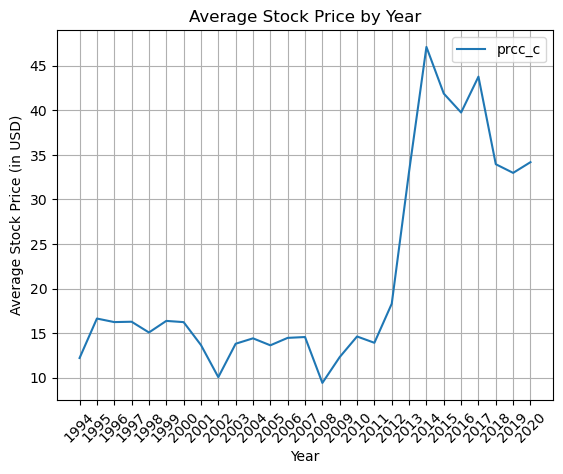

In [12]:
#B-Q4
mean_stock_price_by_year_df = df_pf_chosen.groupby("fyear")["prcc_c"].mean().reset_index()
mean_stock_price_by_year_df.plot(kind="line", x="fyear", y="prcc_c")
plt.xlabel("Year")
plt.xticks(mean_stock_price_by_year_df["fyear"], rotation=45)
plt.title("Average Stock Price by Year")
plt.grid(True)
plt.ylabel("Average Stock Price (in USD)")
plt.show()

In [15]:
#B-Q5 Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?
df_pf_chosen_2007 = df_pf_chosen[df_pf_chosen["fyear"] == 2007]
df_pf_chosen_2008 = df_pf_chosen[df_pf_chosen["fyear"] == 2008]
merged_df = df_pf_chosen_2007.merge(df_pf_chosen_2008, on="conm", suffixes=('_2007', '_2008'))
merged_df_2007_2008 = merged_df[["conm", "prcc_c_2007", "prcc_c_2008"]]
merged_df_2007_2008["percentage_drop"] = ((merged_df_2007_2008["prcc_c_2008"] - merged_df_2007_2008["prcc_c_2007"]) / merged_df_2007_2008["prcc_c_2007"]) * 100
most_affected_firm = merged_df_2007_2008.sort_values("percentage_drop", ascending=True).head(1)
company_name = most_affected_firm["conm"].values[0]
percentage_drop = most_affected_firm["percentage_drop"].values[0]
print(f"The most affected company was: {company_name} with a {percentage_drop:.2f}% drop in stock price from 2007 to 2008.")

The most affected company was: GENTA INC with a -99.48% drop in stock price from 2007 to 2008.


/var/folders/59/h_p32wlx3c3cmmh0jqg0m9040000gn/T/ipykernel_29732/355186072.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2007_2008["percentage_drop"] = ((merged_df_2007_2008["prcc_c_2008"] - merged_df_2007_2008["prcc_c_2007"]) / merged_df_2007_2008["prcc_c_2007"]) * 100


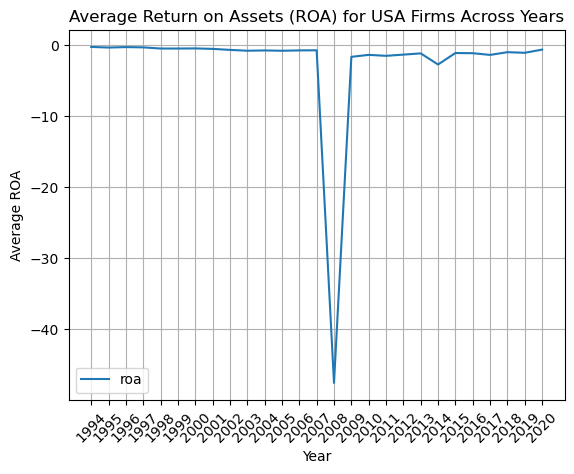

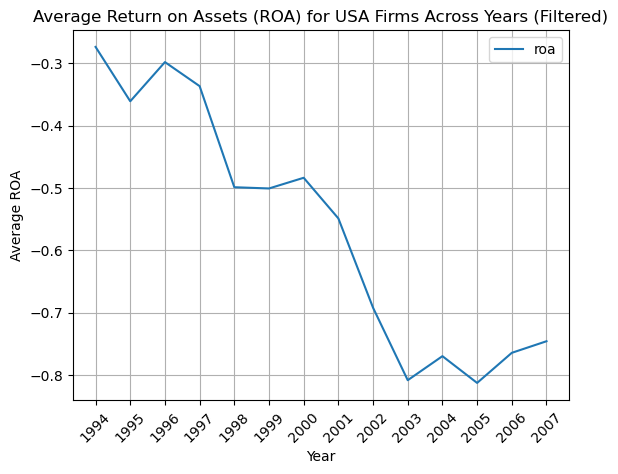

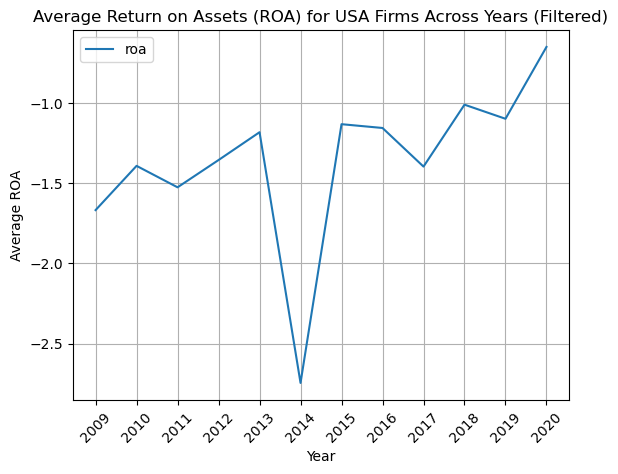

In [16]:
#B-Q6 Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.
roa_in_us = df_pf_chosen[df_pf_chosen["location"] == "USA"].groupby("fyear")["roa"].mean().reset_index()
roa_in_us.plot(kind="line", x="fyear", y="roa")
plt.xlabel("Year")
plt.ylabel("Average ROA")
plt.title("Average Return on Assets (ROA) for USA Firms Across Years")
plt.grid(True)
plt.xticks(roa_in_us["fyear"], rotation=45)
plt.show()
# year 1994-2007
roa_in_us_filtered = roa_in_us[(roa_in_us["fyear"] <= 2007)]
roa_in_us_filtered.plot(kind="line", x="fyear", y="roa")
plt.xlabel("Year")
plt.ylabel("Average ROA")
plt.title("Average Return on Assets (ROA) for USA Firms Across Years (Filtered)")
plt.grid(True)
plt.xticks(roa_in_us_filtered["fyear"], rotation=45)
plt.show()
# year 2009-2020
roa_in_us_filtered = roa_in_us[(roa_in_us["fyear"] >= 2009)]
roa_in_us_filtered.plot(kind="line", x="fyear", y="roa")
plt.xlabel("Year")
plt.ylabel("Average ROA")
plt.title("Average Return on Assets (ROA) for USA Firms Across Years (Filtered)")
plt.grid(True)
plt.xticks(roa_in_us_filtered["fyear"], rotation=45)
plt.show()

### Part 2. Text Analysis on the Industry Sector***

### C. [Text Cleaning; 10 points] The file "data/2020_10K_item1_full.csv" contains a sample of 5,988 firms and their “item_1” content in their 10-K reports in the year 2020.  Load the dataset as a DataFrame and create a new column containing the cleaned text for each “item_1” content. Follow the steps below to clean the text:
1.	***Convert all words into lowercase.***
2.	***Remove punctuations.***
3.	***Remove stop words based on the list of English stop words in NLTK.***


In [18]:
df_10k["item_1_text_lower"] = df_10k["item_1_text"].str.lower()
df_10k["item_1_remove_punc"] = df_10k["item_1_text_lower"].str.translate(str.maketrans('', '', string.punctuation))
df_10k["item_1_remove_stopword"] = df_10k["item_1_remove_punc"].apply(remove_stopwords)

df_10k.head()

,cik,year,name,item_1_text,gvkey,item_1_text_lower,item_1_remove_punc,item_1_remove_stopword
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119,fixed expenses are previosuly documented in an...,fixed expenses are previosuly documented in an...,fixed expenses previosuly documented 8k 235000...
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788,"general hurco companies, inc. is an internatio...",general hurco companies inc is an internationa...,general hurco companies inc international indu...
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584,we have been engaged in the business of develo...,we have been engaged in the business of develo...,engaged business developing marketing products...
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun can capital group (form...,corporate history chun can capital group forme...,corporate history chun capital group formerly ...
12,1593204,2020,Adaiah Distribution Inc,General Adaiah Distribution Inc. was incorpora...,23706,general adaiah distribution inc. was incorpora...,general adaiah distribution inc was incorporat...,general adaiah distribution inc incorporated s...


### D.	Keyword Analysis Conduct keywords analysis on your selected industry sector(s). Follow the steps below to complete the analysis:
1.	***Create a new DataFrame that includes only firms in your selected industry sector(s). Ensure that you merge the 10-K data with the previous "public_firm.csv" data using an inner join.***
2.	***Generate the top 10 keywords for each firm based on two different methods: word counts and TF-IDF score.***
3.	***Create two wordclouds to visualize the keywords across all firms in the selected sector(s): one based on the word counts and another based on the TF-IDF scores.***


In [19]:
df_merged = df_pf_chosen.loc[:,["conm","gvkey"]].drop_duplicates().merge(df_10k, on='gvkey', how="inner")

word_counts_top10 = []
for text in df_merged['item_1_remove_stopword'].tolist():
    word_counts = get_top_keywords(text)
    word_counts_top10.append(word_counts)

corpus = df_merged['item_1_remove_stopword'].tolist()
tfidf_keywords = get_keywords_tfidf(corpus)

# add a new column in the dataframe
df_merged['top_keyword_tfidf'] = tfidf_keywords
df_merged['top_keyword_wordcounts'] = word_counts_top10

Processed 200/798 documents.
Processed 400/798 documents.
Processed 600/798 documents.


In [20]:
pd.options.display.max_colwidth = 500
df_merged.loc[:,['conm','gvkey','item_1_remove_stopword','top_keyword_tfidf','top_keyword_wordcounts']].head(5)

,conm,gvkey,item_1_remove_stopword,top_keyword_tfidf,top_keyword_wordcounts
0,AIR PRODUCTS & CHEMICALS INC,1209,air products chemicals inc delaware corporation originally founded 1940 serves customers globally unique portfolio products services solutions include atmospheric gases process specialty gases equipment services world largest supplier hydrogen built leading positions growth markets helium liquefied natural gas lng process technology equipment also develop engineer build operate world largest industrial gas projects including gasification projects sustainably convert abundant natural resource...,gases helium industrial gas hydrogen syngas gasification equipment ghg atmospheric,gases industrial equipment gas including 2020 business customers hydrogen financial
1,AMERICAN VANGUARD CORP,1585,american vanguard corporation avd incorporated laws state delaware january 1969 operates holding company unless context otherwise requires references company registrant annual report refer avd company conducts business subsidiaries amvac chemical corporation amvac gemchem inc gemchem amvac mexico sociedad de responsabilidad limitada amvac amvac de costa rica sociedad de responsabilidad limitada amvac cr srl amvac cv amvac cv amvac hong kong limited amvac hong kong amvac netherlands bv amvac ...,amvac avd bv company tyratech dtsc agricenter crop products agrovant,amvac company products avd assets product bv owned subsidiary 2017
2,AMGEN INC,1602,amgen inc including subsidiaries referred amgen company us committed unlocking potential biology patients suffering serious illnesses discovering developing manufacturing delivering innovative human therapeutics approach begins using tools like advanced human genetics unravel complexities disease understand fundamentals human biology amgen focuses areas high unmet medical need leverages expertise strive solutions improve health outcomes dramatically improve people lives biotechnology pioneer...,kyprolis mr products us product vice abp amg amgen united,products us product united states patients europe clinical may fda
3,ASHLAND GLOBAL HOLDINGS INC,1794,general ashland global holdings inc delaware corporation headquarters principal executive offices 8145 blazer drive wilmington delaware 19808 telephone 302 9953000 ashland global holdings inc incorporated 2016 successor kentucky corporation named ashland inc organized 2004 known ashland llc organized successor kentucky corporation name organized 1936 ashland global holdings inc replaced ashland inc publicly held corporation ashland inc converted kentucky limited liability company indirect wh...,ashland adhesives rheology additives industrial polymers specialty household products remediation,ashland products specialty care include industrial additives adhesives personal environmental
4,REX AMERICAN RESOURCES CORP,1864,references us rex company refer rex american resources corporation majority owned subsidiaries fiscal year references report particular fiscal year rex fiscal year ended january 31 example fiscal year 2019 means period february 1 2019 january 31 2020 refer fiscal year reference year immediately preceding january 31 fiscal year end date overview rex incorporated delaware 1984 holding company principal offices located 7720 paragon road dayton ohio 45459 telephone number 937 2763931 investor et...,ethanol epa coal corn gallons fuel renewable refined rfs gasoline,ethanol epa year corn fuel 2019 coal renewable fiscal energy


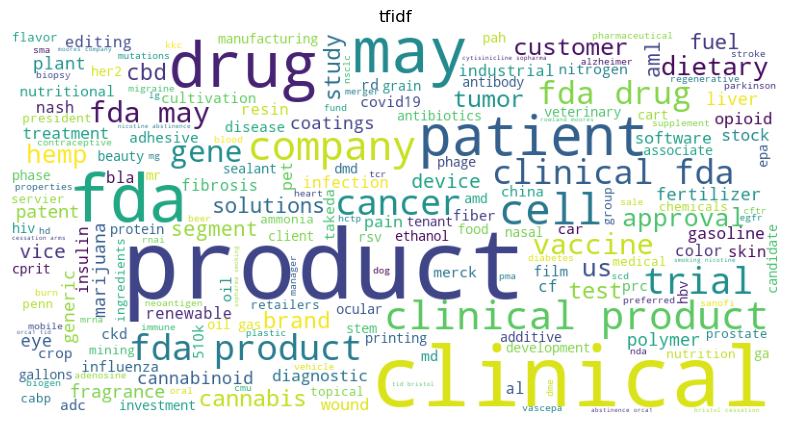

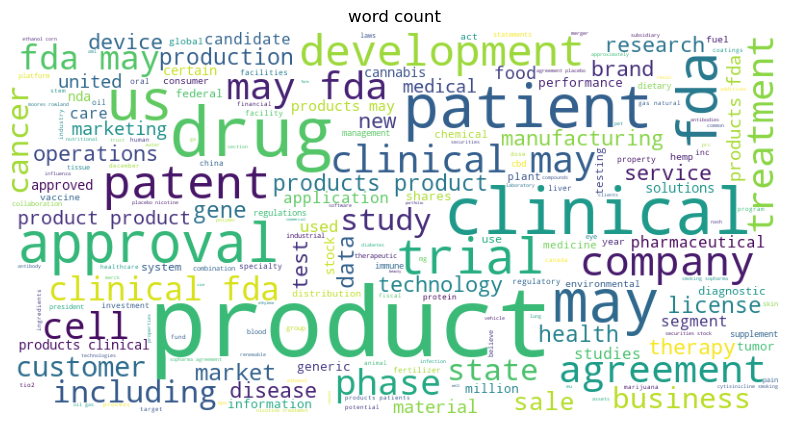

In [21]:
wordcloud_tfidf = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(' '.join(df_merged['top_keyword_tfidf'].tolist())) # note that text is a string, not a list
wordcloud_wc = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(' '.join(df_merged['top_keyword_wordcounts'].tolist()))

plt.figure(figsize=(10,5))
plt.axis('off')
plt.title("tfidf")
plt.imshow(wordcloud_tfidf)
plt.show()

plt.figure(figsize=(10,5))
plt.axis('off')
plt.title("word count")
plt.imshow(wordcloud_wc)
plt.show()

### E.	[Word embedding; 20 points] Train a word2vec model and analyze word similarities.
1.	***Train a word2vec model with the full 10-K sample (e.g., "data/2020_10K_item1_full.csv"). Please use the cleaned text (e.g., results from Step C) for training.***
2.	***Manually inspect the wordclouds you generated in D.3 and choose three representative keywords that are relevant to the industry sector of your interest. Utilize the trained word2vec model to find the most relevant five words for each of these three keywords.***


In [22]:
texts = [row.split() for row in df_merged["item_1_remove_stopword"]]
word2vec_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=5, workers=4)

print_five_words('product')
print_five_words('clinical')
print_five_words('fda')

Similar words to "product" are : products, drug, biologic, bla, drugs
Similar words to "clinical" are : laterstage, confirmatory, pivotal, registrational, ongoing
Similar words to "fda" are : bla, pma, premarket, nda, sponsor


### Part 3. Comprehensive Analysis of One Sample Firm
### F.	[Firm Analysis and Strategy Suggestion; 10 points] This is an open question. Pick one firm that your group is interested in and try to analyze its market status. The ultimate goal is to provide one valuable suggestion to the firm based on your analysis. Some directions you might consider are, but not limited to:
1.	***Convert the keywords extracted in D.2 into word embeddings with the word2vec model trained in E.1. Add up the embeddings for each firm to create the firm-level embeddings. Use the firm-level embeddings to find the focal firm’s competing firms (or most similar firms).***
2.	***Compare the revenue, market share, and ROA of the focal firm to its competitors and provide suggestions accordingly.***
3.	***Perform an analysis of the historical stock prices, ROA, revenue, and assets of the chosen firm. Investigate potential correlations and address noteworthy decreases and increases.***



In [25]:
from DocumentSimilarity import DocumentSimilarity
docsim = DocumentSimilarity(model = word2vec_model, gvkeys=df_merged['gvkey'], conm = df_merged['conm'],
                       keywordslist = df_merged['top_keyword_tfidf'])

type(docsim)

DocumentSimilarity.DocumentSimilarity

In [26]:
#NEOGEN CORP
most_similiar_firms = docsim.most_similar(firm = 16453, topn = 5) 
print(most_similiar_firms)

[(23297, 'XBIOTECH INC', 0.90262175), (30391, 'BALTIC INTL USA INC', 0.8449027), (7637, 'VIATRIS INC', 0.817745), (62475, 'ARBUTUS BIOPHARMA CORP', 0.79431343), (254381, 'BENITEC BIOPHARMA LTD', 0.7745079)]


<Axes: xlabel='Year', ylabel='ROA'>

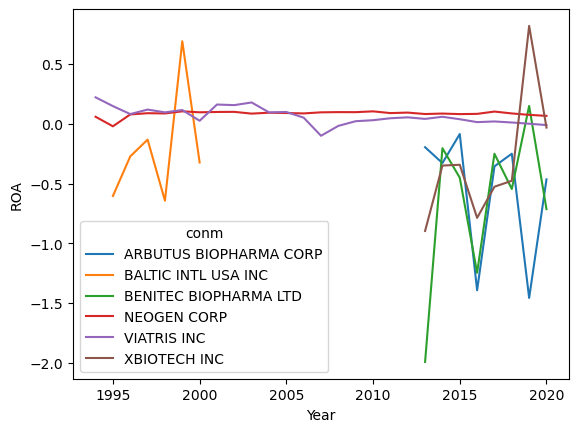

In [27]:
gvkeys_of_similiar_companies = [companies[0] for companies in most_similiar_firms]
df_similiar_companies = df_pf_chosen[df_pf_chosen['gvkey'].isin([16453] + gvkeys_of_similiar_companies)]
df_similiar_companies.pivot(index='fyear', columns='conm', values='roa').plot(xlabel='Year',ylabel='ROA')

Based on the graph, it seems that Neogen Corp (represented by the green line) has maintained relatively stable performance in terms of Return on Assets (ROA) over the years, however, their competitors have more ups and downs during years.  Since the company's ROA is stable, Neogen could explore expansion into new markets or consider acquisitions that extends its existing operations to boost profitability without causing significant disruptions to the ROA trend.

<Axes: xlabel='Year', ylabel='Revenue'>

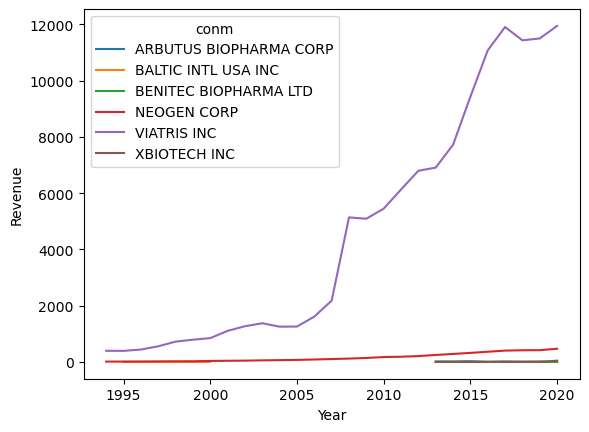

In [28]:
df_similiar_companies.pivot(index='fyear', columns='conm', values='sale').plot(xlabel='Year',ylabel='Revenue')

Viatris has put more revenue during years and increase the gap between Neogen Corp; however, Neogen Corp's steady growth reflects a consistent performance, but there is room to accelerate this growth. Expanding into new markets, exploring higher-growth industries, and building strategic partnerships might help Neogen to increase its revenue trajectory over the next few years.

/var/folders/59/h_p32wlx3c3cmmh0jqg0m9040000gn/T/ipykernel_29732/3011750307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_similiar_companies['market_share'] = df_similiar_companies.apply(lambda row: row['sale'] / total_sales_by_year[row['fyear']], axis=1)


<Axes: xlabel='Year', ylabel='Market Share'>

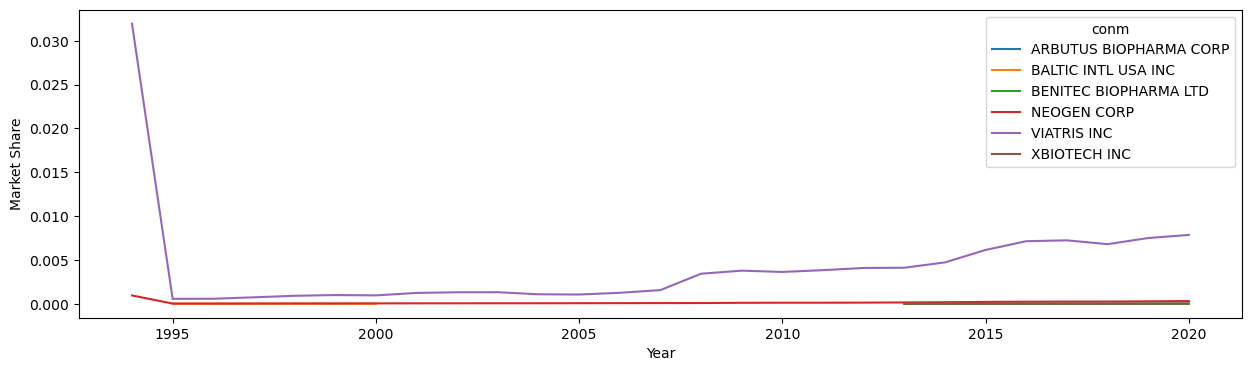

In [29]:
total_sales_by_year = df_pf_chosen.groupby("fyear").sum()['sale']
df_similiar_companies['market_share'] = df_similiar_companies.apply(lambda row: row['sale'] / total_sales_by_year[row['fyear']], axis=1)
df_similiar_companies.pivot(index='fyear', columns='conm', values='market_share').plot(xlabel='Year',ylabel='Market Share',figsize=(15,4))

While Neogen Corp's market share is stable, it is not showing significant growth compared to competitors like Viatris, which has been gaining market share since 2010. To address this, Neogen should focus on market expansion, product diversification.


<Axes: xlabel='Year', ylabel='Asset'>

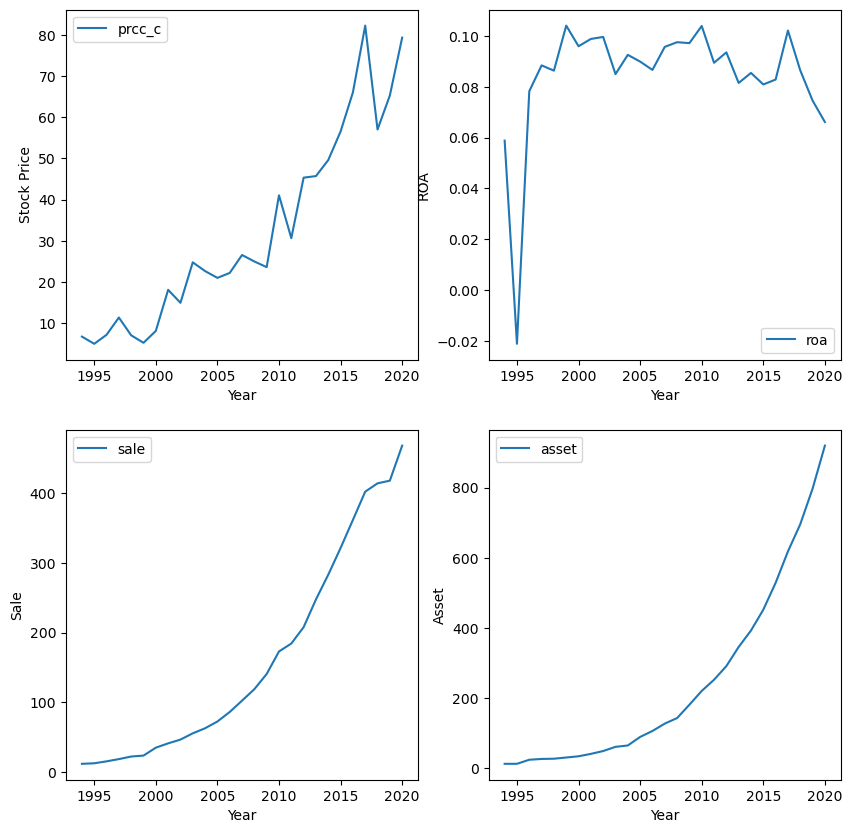

In [30]:
df_neogen = df_pf_chosen[df_pf_chosen['gvkey'] == 16453]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

df_neogen.plot(x='fyear',y='prcc_c',xlabel='Year',ylabel='Stock Price',ax=axs[0, 0])
df_neogen.plot(x='fyear',y='roa',xlabel='Year',ylabel='ROA',ax=axs[0, 1])
df_neogen.plot(x='fyear',y='sale',xlabel='Year',ylabel='Sale',ax=axs[1, 0])
df_neogen.plot(x='fyear',y='asset',xlabel='Year',ylabel='Asset',ax=axs[1, 1])

Both sales and stock price show a clear upward trend, particularly after 2010, suggesting a strong positive correlation between the company's revenue growth and its stock market performance. Assets and sales both increase significantly from 2010 onward. This suggests the company may be using its growing asset base effectively to generate revenue, indicating an efficient utilization of resources. The ROA shows early volatility but stabilizes after 2000, while the stock price continues to rise. However, the slight dip in ROA around 2015 may have contributed to the stock price volatility around the same time. As noteworthy changes, tthe sharp drop in ROA around 1995, followed by a quick recovery, may indicate a period of restructuring or investment in growth. Moreover, the steep rise in stock price after 2010 could be driven by the corresponding increase in sales and assets, showing strong company growth.